In [1]:
import os
import glob
import h5py
import fitsio
import numpy as np 

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from redrock import templates
from desitarget.cmx import cmx_targetmask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# read VI table
fvi = os.path.join('/global/cfs/cdirs/desi/sv/vi/TruthTables/', 'truth_table_BGS_full_66003.txt')#'truth_table_BGS_v1.1.csv')

zrr_vi, ztrue, qa_flag, dchi2_vi, zwarn_vi, rflux_vi, vi_ra, vi_dec = np.genfromtxt(fvi, delimiter=',', skip_header=1, unpack=True, usecols=[2, 4, 6, 11, 12, 16, -2, -1])# usecols=[0, 1, 2, 3, 10, 11, 15])

fvi = os.path.join(fvi)
vi_id = Table.read(fvi, format='ascii.csv', include_names=['TargetID'])['TargetID']
vi_id = np.array(vi_id).astype(int)

In [4]:
dir_coadd = '/global/cfs/cdirs/desi/users/chahah/bgs_exp_coadd/'

In [5]:
# exposures of VI tile
expids = np.unique([int(fcoadd.split('-')[-1].replace('.fits', '')) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*.fits'))])

--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
  60 of 2241 have QA flag < 2.5
  84 of 2241 have delta z/(1+z) > 0.003
146 311 165
0.06514948683623382 0.13877733154841587 0.07362784471218206
54 146
0.3698630136986301
58 311
0.1864951768488746
0.024242424242424242


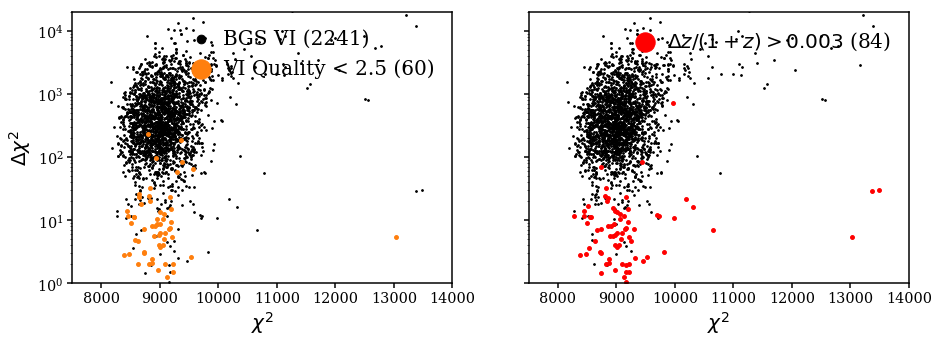

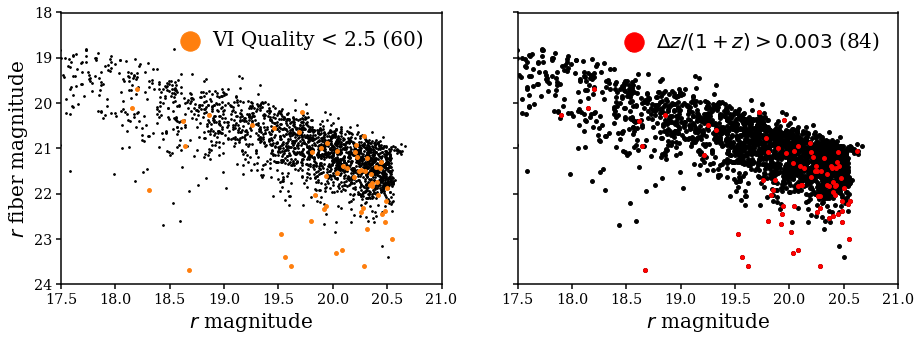

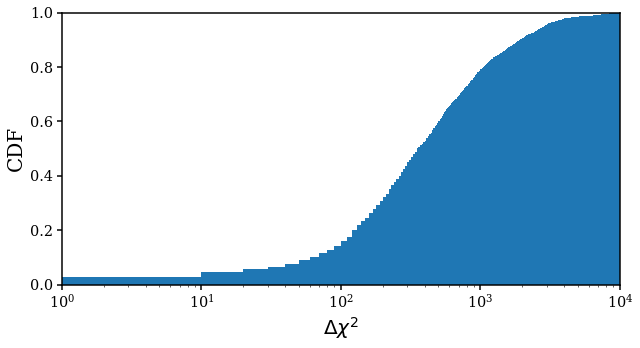

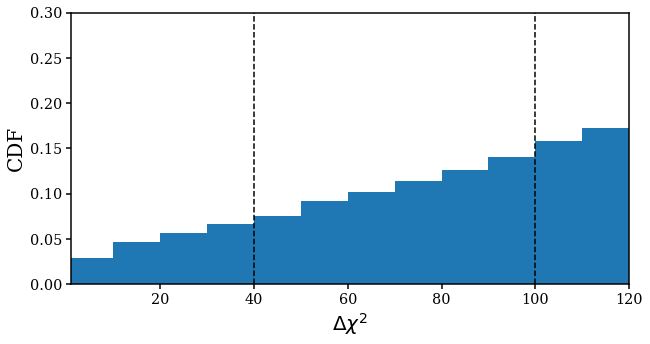

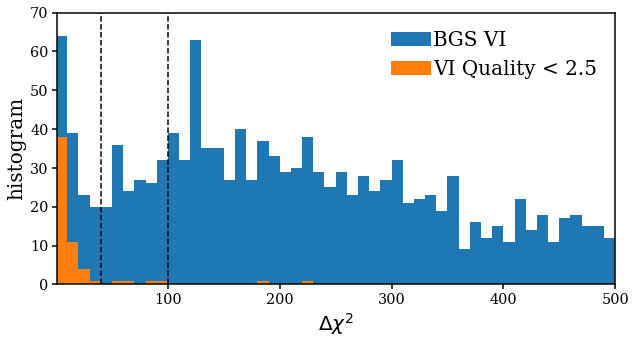

In [6]:
for i_exp, expid in enumerate(expids[:1]): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_bgs, n_match = 0, 0
    ids, fluxes, rmags, rfibs, z_rrs, zwarns, chi2s, dchi2s = [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        ids.append(coadd['TARGETID'][gal_cut])
        fluxes.append(coadd_flux)
        
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])

        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
         
    
    # match VI targets to coadd targets 
    ids = np.concatenate(ids)
    _, m_vi, _m_coadd = np.intersect1d(vi_id, ids, return_indices=True)
    isort = np.argsort(m_vi)
    m_coadd = _m_coadd[isort]
    assert np.array_equal(m_vi[isort], np.arange(len(vi_id)))
    print('  %i of %i BGS targets have matches to VI' % (len(m_vi), n_bgs))
    assert np.array_equal(vi_id, ids[m_coadd])
    
    fluxes = np.concatenate(fluxes)[m_coadd]

    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]

    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
        
    bad_vi = (qa_flag < 2.5)
    print('  %i of %i have QA flag < 2.5' % (np.sum(bad_vi), len(bad_vi)))
    
    rr_mismatch = np.abs(z_rrs - ztrue)/(1. + ztrue) > 0.003
    print('  %i of %i have delta z/(1+z) > 0.003' % (np.sum(rr_mismatch), len(rr_mismatch)))
    
    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(121)
    sub.scatter(chi2s, dchi2s, s=3, c='k', label='BGS VI (%i)' % len(bad_vi))
    sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_ylim(1., 2e4)
    sub.set_yscale('log')
    
    sub = fig.add_subplot(122)
    sub.scatter(chi2s, dchi2s, s=3, c='k')
    sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=15, c='r', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(7500., 14000)
    sub.set_ylim(1., 2e4)
    sub.set_yscale('log')
    sub.set_yticklabels([])

    fig = plt.figure(figsize=(15, 5))
    sub = fig.add_subplot(121)
    sub.scatter(rmags, rfibs, c='k', s=3)
    sub.scatter(rmags[bad_vi], rfibs[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)    
    sub.set_xlabel(r'$r$ magnitude', fontsize=20)
    sub.set_xlim(17.5, 21)
    sub.set_ylabel(r'$r$ fiber magnitude', fontsize=20)
    sub.set_ylim(24., 18)    
    sub = fig.add_subplot(122)
    sub.scatter(rmags, rfibs, s=15, c='k')    
    sub.scatter(rmags[rr_mismatch], rfibs[rr_mismatch], s=15, c='r', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$r$ magnitude', fontsize=20)
    sub.set_xlim(17.5, 21)
    sub.set_ylim(24., 18)
    sub.set_yticklabels([])    
    
    fig = plt.figure(figsize=(10, 5))
    sub = fig.add_subplot(111)
    sub.hist(dchi2s, range=(0, 1e4), cumulative=True, density=True, bins=1000)
    sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_xlim(1, 1e4)
    sub.set_xscale('log')
    sub.set_ylabel('CDF', fontsize=20)
    sub.set_ylim(0., 1.)
    
    fig = plt.figure(figsize=(10, 5))
    sub = fig.add_subplot(111)
    sub.hist(dchi2s, range=(0, 1e4), cumulative=True, density=True, bins=1000)
    sub.plot([40., 40.], [0., 1.], c='k', ls='--')
    sub.plot([100., 100.], [0., 1.], c='k', ls='--')
    sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_xlim(1, 120)
    sub.set_ylabel('CDF', fontsize=20)
    sub.set_ylim(0., 0.3)
    
    
    fig = plt.figure(figsize=(10, 5))
    sub = fig.add_subplot(111)
    sub.hist(dchi2s, range=(0, 1e4), bins=1000, label='BGS VI')
    sub.hist(dchi2s[bad_vi], range=(0, 1e4), bins=1000, label='VI Quality < 2.5')
    sub.plot([40., 40.], [0., 100.], c='k', ls='--')
    sub.plot([100., 100.], [0., 100.], c='k', ls='--')    
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1)
    sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_xlim(1, 500)
    #sub.set_xscale('log')
    sub.set_ylabel('histogram', fontsize=20)
    sub.set_ylim(0., 70.)    
    
    print(np.sum(dchi2s < 40), np.sum(dchi2s < 100), np.sum((dchi2s > 40) & (dchi2s < 100)))
    print(np.sum(dchi2s < 40)/len(dchi2s), np.sum(dchi2s < 100)/len(dchi2s), np.sum((dchi2s > 40) & (dchi2s < 100))/len(dchi2s))    
    print(np.sum(bad_vi & (dchi2s < 40)), np.sum(dchi2s < 40))
    print(np.sum(bad_vi & (dchi2s < 40))/np.sum(dchi2s < 40))

    print(np.sum(bad_vi & (dchi2s < 100)), np.sum(dchi2s < 100))
    print(np.sum(bad_vi & (dchi2s < 100))/np.sum(dchi2s < 100))    
    print(np.sum(bad_vi & (dchi2s > 40) & (dchi2s < 100))/np.sum((dchi2s > 40) & (dchi2s < 100)))

In [7]:
galaxy_templates = templates.Template('rrtemplate-galaxy.fits')

DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
31 targets with chi2 > 12000
  of these 1 are flagged in VI
  of these 4 have wrong redshifts
  of these 4 are flagged by redrock
[16405.16284764 13033.62548125 13485.32870436 13369.21445724]
[16.33936894  5.49354499 29.93421876 29.45824793]


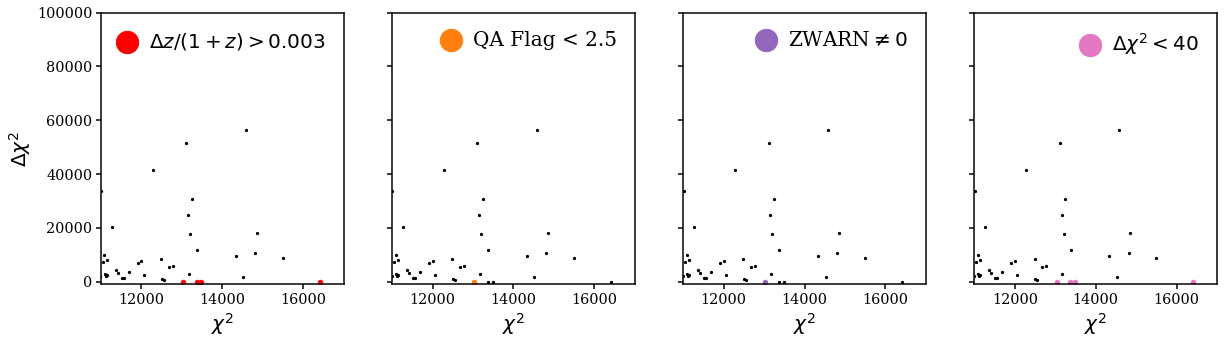

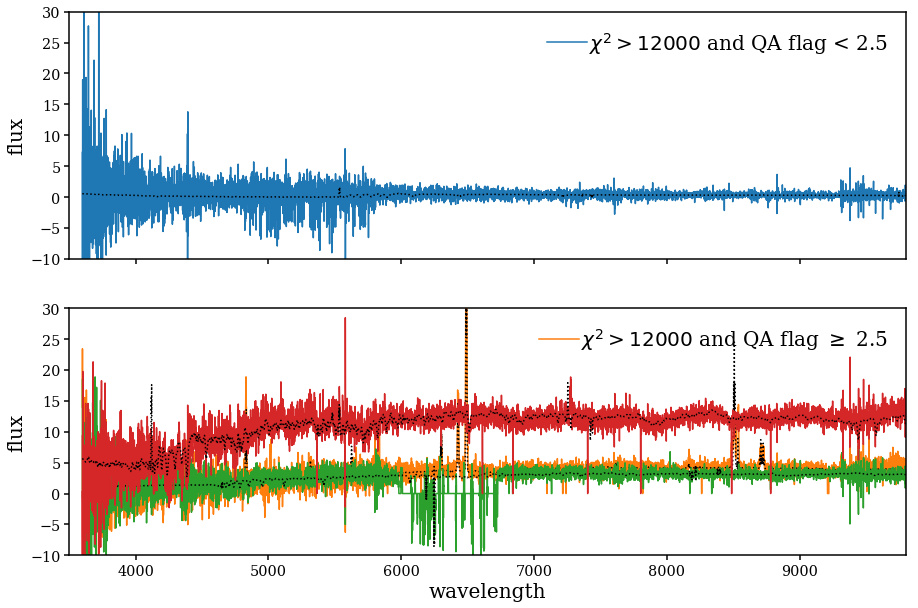

In [8]:
for i_exp, expid in enumerate(expids[:1]): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_bgs, n_match = 0, 0
    ids, fluxes, rmags, rfibs, z_rrs, zwarns, zcoeffs, chi2s, dchi2s = [], [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        ids.append(coadd['TARGETID'][gal_cut])
        fluxes.append(coadd_flux)
        
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])
        
        zcoeffs.append(zbest['COEFF'][gal_cut])

        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
         
    
    # match VI targets to coadd targets 
    ids = np.concatenate(ids)
    _, m_vi, _m_coadd = np.intersect1d(vi_id, ids, return_indices=True)
    isort = np.argsort(m_vi)
    m_coadd = _m_coadd[isort]
    assert np.array_equal(m_vi[isort], np.arange(len(vi_id)))
    print('  %i of %i BGS targets have matches to VI' % (len(m_vi), n_bgs))
    assert np.array_equal(vi_id, ids[m_coadd])
    
    fluxes = np.concatenate(fluxes)[m_coadd]

    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]
    
    zcoeffs = np.concatenate(zcoeffs, axis=0)[m_coadd]

    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
    
    not_empty = np.sum(fluxes, axis=1) != 0.
    # targets with very high chi2
    high_chi2 = (chi2s > 12000) & not_empty
    print('%i targets with chi2 > 12000' % np.sum(high_chi2))
    qa_flagged = (qa_flag < 2.5)
    print('  of these %i are flagged in VI' % np.sum(high_chi2 & qa_flagged))
    rr_mismatch = np.abs(z_rrs - ztrue)/(1. + ztrue) > 0.003
    print('  of these %i have wrong redshifts' % np.sum(high_chi2 & rr_mismatch))
    rr_flagged = (zwarns != 0) | (dchi2s < 40)
    print('  of these %i are flagged by redrock' % np.sum(high_chi2 & rr_mismatch & rr_flagged))
    high_chi2_flagged = high_chi2 & qa_flagged
    high_chi2_notflagged = high_chi2 & ~qa_flagged
    

    print(chi2s[high_chi2 & rr_mismatch & rr_flagged])
    print(dchi2s[high_chi2 & rr_mismatch & rr_flagged])
    
    
    fig = plt.figure(figsize=(20, 5))
    sub = fig.add_subplot(141)
    sub.scatter(chi2s, dchi2s, s=5, c='k')
    sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=20, c='r', label=r'$\Delta z/(1+z) > 0.003$')
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(11000., 17000)
    sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
    sub.set_ylim(-1e3, 1e5)       
    
    sub = fig.add_subplot(142)
    sub.scatter(chi2s, dchi2s, s=5, c='k')
    sub.scatter(chi2s[qa_flagged], dchi2s[qa_flagged], s=20, c='C1', label='QA Flag < 2.5')
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(11000., 17000)
    sub.set_ylim(-1e3, 1e5)    
    sub.set_yticklabels([])
    
    sub = fig.add_subplot(143)
    sub.scatter(chi2s, dchi2s, s=5, c='k')
    sub.scatter(chi2s[zwarns != 0], dchi2s[zwarns != 0], s=20, c='C4', label=r'ZWARN$\neq 0$')
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(11000., 17000)
    sub.set_ylim(-1e3, 1e5)    
    sub.set_yticklabels([])
    
    sub = fig.add_subplot(144)
    sub.scatter(chi2s, dchi2s, s=5, c='k')
    sub.scatter(chi2s[dchi2s < 40], dchi2s[dchi2s < 40], s=20, c='C6', label=r'$\Delta \chi^2 < 40$')
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'$\chi^2$', fontsize=20)
    sub.set_xlim(11000., 17000)
    sub.set_ylim(-1e3, 1e5)    
    sub.set_yticklabels([])

    fig = plt.figure(figsize=(15, 10))
    sub = fig.add_subplot(211)

    sub.plot(coadd_wave, fluxes[high_chi2_flagged,:][0], label='$\chi^2 > 12000$ and QA flag < 2.5')
    bestfit_template = galaxy_templates.eval(zcoeffs[high_chi2_flagged,:][0], coadd_wave, z_rrs[high_chi2_flagged][0]) * (1+z_rrs[high_chi2_flagged][0])
    sub.plot(coadd_wave, bestfit_template, c='k', ls=':')

    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlim(3.5e3, 9.8e3)
    sub.set_xticklabels([])
    sub.set_ylabel(r'flux', fontsize=20)
    sub.set_ylim(-10, 30)   
    
    sub = fig.add_subplot(212)    
    sub.plot([], [])
    sub.plot(coadd_wave, fluxes[high_chi2_notflagged,:][0], label='$\chi^2 > 12000$ and QA flag $\geq$ 2.5')
    bestfit_template = galaxy_templates.eval(zcoeffs[high_chi2_notflagged,:][0], coadd_wave, z_rrs[high_chi2_notflagged][0]) * (1+z_rrs[high_chi2_notflagged][0])
    sub.plot(coadd_wave, bestfit_template, c='k', ls=':')
    
    for i in range(3, 5):#np.sum(high_chi2_notflagged)): 
        sub.plot(coadd_wave, fluxes[high_chi2_notflagged,:][i])
        bestfit_template = galaxy_templates.eval(zcoeffs[high_chi2_notflagged,:][i], coadd_wave, z_rrs[high_chi2_notflagged][i]) * (1+z_rrs[high_chi2_notflagged][i])
        sub.plot(coadd_wave, bestfit_template, c='k', ls=':')
    sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
    sub.set_xlabel(r'wavelength', fontsize=20)
    sub.set_xlim(3.5e3, 9.8e3)
    sub.set_ylabel(r'flux', fontsize=20)
    sub.set_ylim(-10, 30)

--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
2095 targets with dchi2 > 40
  of these 6 are flagged in VI


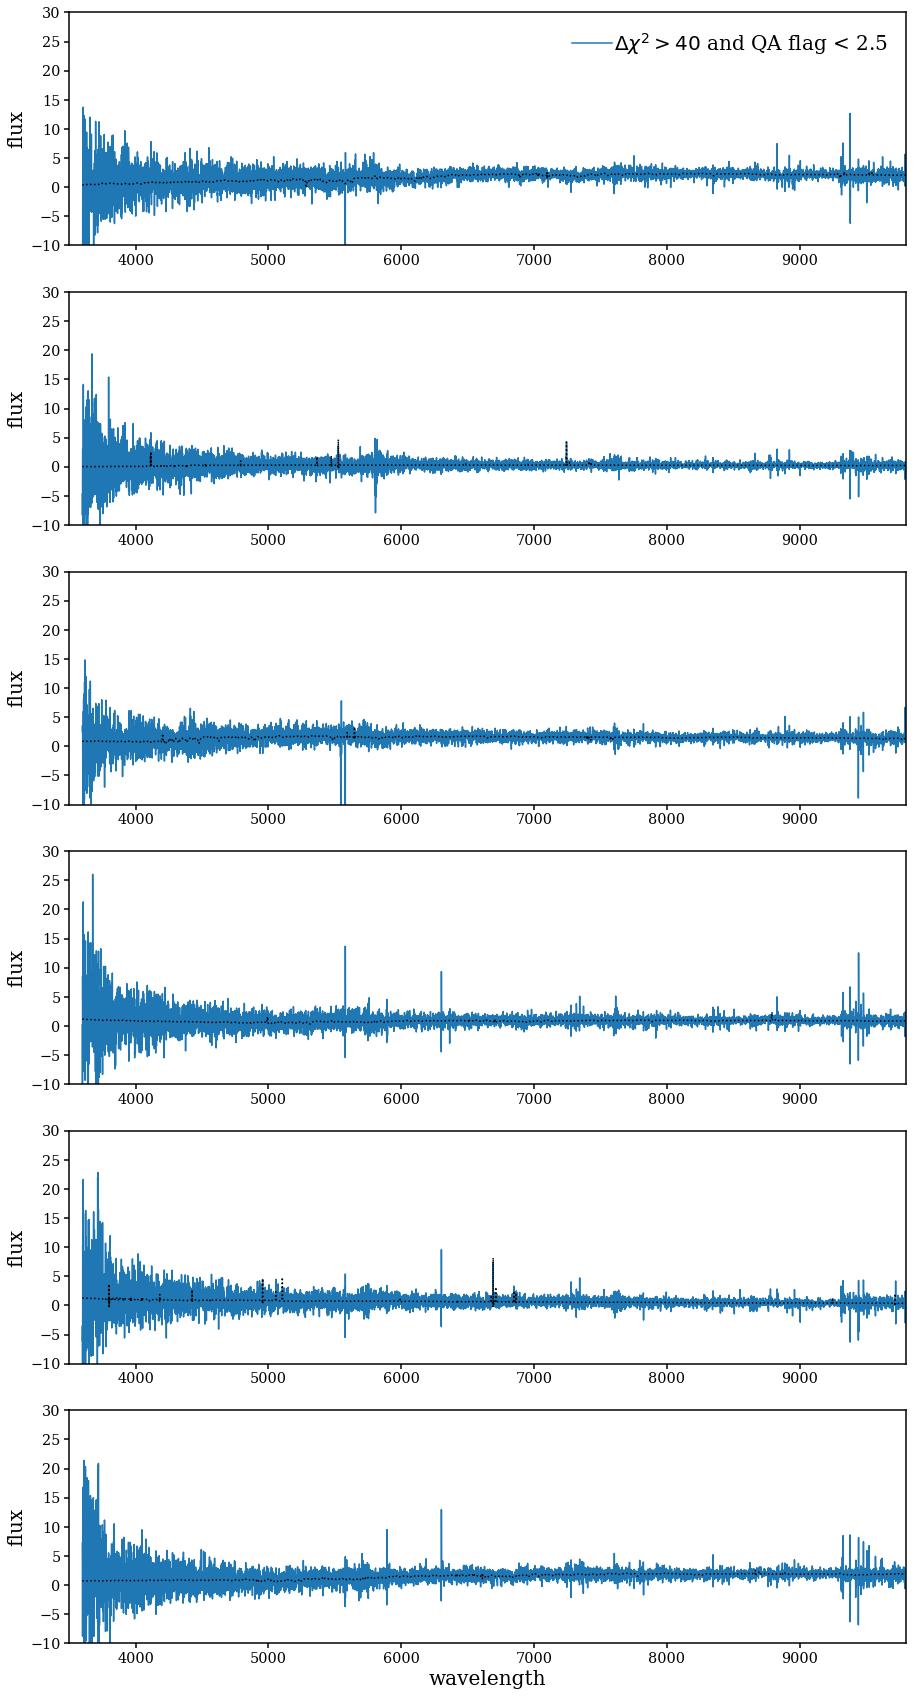

In [9]:
for i_exp, expid in enumerate(expids[:1]): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_bgs, n_match = 0, 0
    ids, fluxes, rmags, rfibs, z_rrs, zwarns, zcoeffs, chi2s, dchi2s = [], [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        ids.append(coadd['TARGETID'][gal_cut])
        fluxes.append(coadd_flux)
        
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])
        
        zcoeffs.append(zbest['COEFF'][gal_cut])

        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
         
    
    # match VI targets to coadd targets 
    ids = np.concatenate(ids)
    _, m_vi, _m_coadd = np.intersect1d(vi_id, ids, return_indices=True)
    isort = np.argsort(m_vi)
    m_coadd = _m_coadd[isort]
    assert np.array_equal(m_vi[isort], np.arange(len(vi_id)))
    print('  %i of %i BGS targets have matches to VI' % (len(m_vi), n_bgs))
    assert np.array_equal(vi_id, ids[m_coadd])
    
    fluxes = np.concatenate(fluxes)[m_coadd]

    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]
    
    zcoeffs = np.concatenate(zcoeffs, axis=0)[m_coadd]

    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
    
    # targets with very high chi2
    high_dchi2 = (dchi2s > 40.)
    print('%i targets with dchi2 > 40' % np.sum(high_dchi2))
    qa_flagged = (qa_flag < 2.5)
    why_flagged = high_dchi2 & qa_flagged
    print('  of these %i are flagged in VI' % np.sum(why_flagged))
    
    fig = plt.figure(figsize=(15, np.sum(why_flagged)*5))
    for i in range(np.sum(why_flagged)):
        sub = fig.add_subplot(np.sum(why_flagged), 1, i+1)
        sub.plot(coadd_wave, fluxes[why_flagged,:][i], label='$\Delta \chi^2 > 40$ and QA flag < 2.5')
        bestfit_template = galaxy_templates.eval(zcoeffs[why_flagged,:][i], coadd_wave, z_rrs[why_flagged][i]) * (1+z_rrs[why_flagged][i])
        sub.plot(coadd_wave, bestfit_template, c='k', ls=':')    

        if i == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
        sub.set_xlim(3.5e3, 9.8e3)
        sub.set_ylabel(r'flux', fontsize=20)
        sub.set_ylim(-10, 30)
    sub.set_xlabel(r'wavelength', fontsize=20)


--- 55654 ---


/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
1682 targets with r_fib > 20.5
  of these 53 targets have QA flag < 2.5


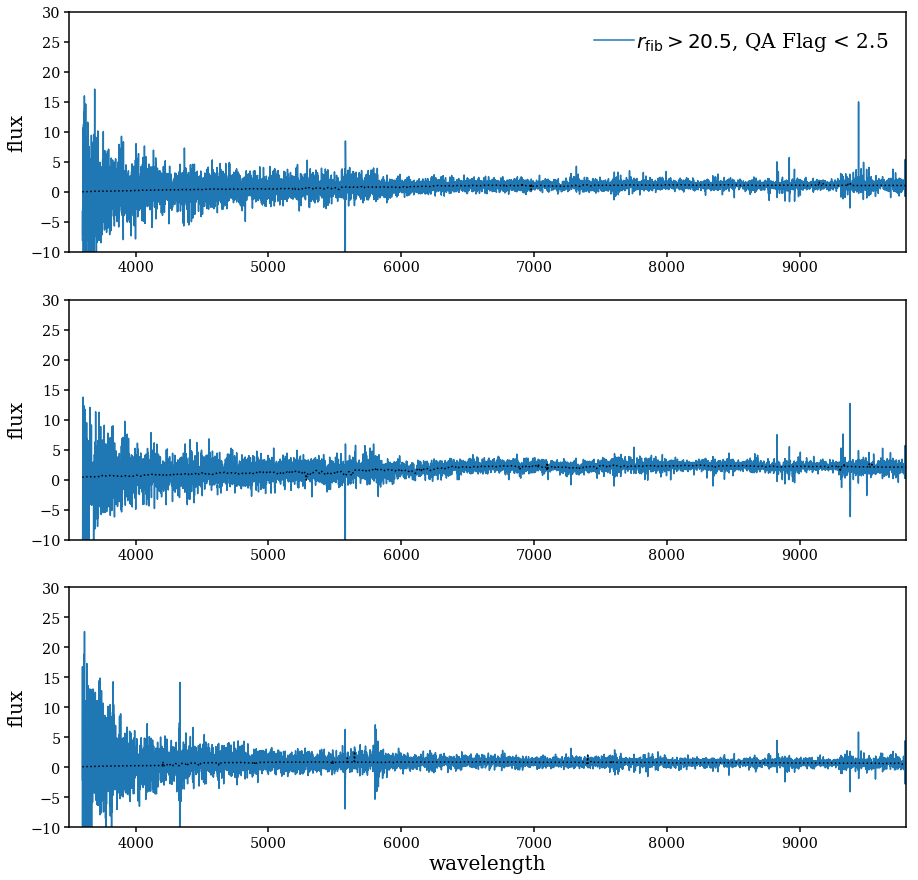

In [10]:
for i_exp, expid in enumerate(expids[:1]): 
    print('--- %i ---' % expid)
    petals = np.unique([int(fcoadd.split('-')[-2]) for fcoadd in glob.glob(os.path.join(dir_coadd, 'coadd-66003-20200315-*%i.fits' % expid))])
    
    n_bgs, n_match = 0, 0
    ids, fluxes, rmags, rfibs, z_rrs, zwarns, zcoeffs, chi2s, dchi2s = [], [], [], [], [], [], [], [], []
    for petal in petals: 
        # read coadd file
        f_coadd = os.path.join(dir_coadd, 'coadd-66003-20200315-%i-%s.fits' % (petal, str(expid).zfill(8)))
        coadd = fitsio.read(f_coadd)
                
        coadd_wave = fitsio.read(f_coadd, ext=2)
        coadd_flux = fitsio.read(f_coadd, ext=3)
        
        # read zbest files
        f_zbest = f_coadd.replace('coadd-', 'zbest-')
        zbest = fitsio.read(f_zbest)
  
        # only keep BGS targets
        is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
        # remove galaxies with no flux...
        gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
        n_bgs += np.sum(gal_cut)
        
        ids.append(coadd['TARGETID'][gal_cut])
        fluxes.append(coadd_flux)
        
        rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
        rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))
        
        z_rrs.append(zbest['Z'][gal_cut])
        zwarns.append(zbest['ZWARN'][gal_cut])
        
        zcoeffs.append(zbest['COEFF'][gal_cut])

        chi2s.append(zbest['CHI2'][gal_cut])
        dchi2s.append(zbest['DELTACHI2'][gal_cut])
         
    
    # match VI targets to coadd targets 
    ids = np.concatenate(ids)
    _, m_vi, _m_coadd = np.intersect1d(vi_id, ids, return_indices=True)
    isort = np.argsort(m_vi)
    m_coadd = _m_coadd[isort]
    assert np.array_equal(m_vi[isort], np.arange(len(vi_id)))
    print('  %i of %i BGS targets have matches to VI' % (len(m_vi), n_bgs))
    assert np.array_equal(vi_id, ids[m_coadd])
    
    fluxes = np.concatenate(fluxes)[m_coadd]

    rmags = np.concatenate(rmags)[m_coadd]
    rfibs = np.concatenate(rfibs)[m_coadd]

    z_rrs = np.concatenate(z_rrs)[m_coadd]
    zwarns = np.concatenate(zwarns)[m_coadd]
    
    zcoeffs = np.concatenate(zcoeffs, axis=0)[m_coadd]

    chi2s = np.concatenate(chi2s)[m_coadd]
    dchi2s = np.concatenate(dchi2s)[m_coadd]
    
    # targets with very high chi2
    low_sb = (rfibs > 20.5)
    print('%i targets with r_fib > 20.5' % np.sum(low_sb))
    qa_flagged = (qa_flag < 2.5)
    print('  of these %i targets have QA flag < 2.5' % np.sum(low_sb & qa_flagged))
    
    low_sb_qa_flagged = low_sb & qa_flagged
    
    fig = plt.figure(figsize=(15, 15))

    for i in range(np.sum(low_sb_qa_flagged))[:3]:
        sub = fig.add_subplot(3,1,i+1)

        sub.plot(coadd_wave, fluxes[low_sb_qa_flagged,:][i], label=r'$r_{\rm fib} > 20.5$, QA Flag < 2.5')
        bestfit_template = galaxy_templates.eval(zcoeffs[low_sb_qa_flagged,:][i], coadd_wave, z_rrs[low_sb_qa_flagged][i]) * (1+z_rrs[low_sb_qa_flagged][i])
        sub.plot(coadd_wave, bestfit_template, c='k', ls=':')    

        if i == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
        sub.set_xlim(3.5e3, 9.8e3)
        sub.set_ylabel(r'flux', fontsize=20)
        sub.set_ylim(-10, 30)
    sub.set_xlabel(r'wavelength', fontsize=20)


# Combined Exposures (3x450)

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log10


  2241 of 5000 BGS targets have matches to VI
  60 of 2241 have QA flag < 2.5
  43 of 2241 have delta z/(1+z) > 0.003
58 96 38
0.025881302989736725 0.0428380187416332 0.016956715751896476
43 58
0.7413793103448276
52 96
0.5416666666666666
0.23684210526315788


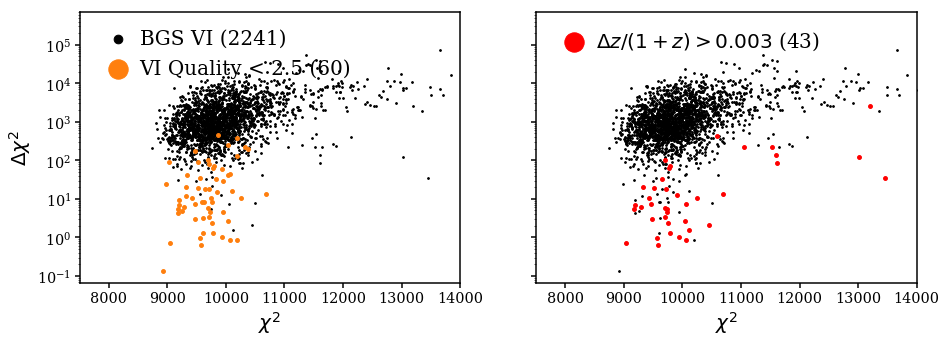

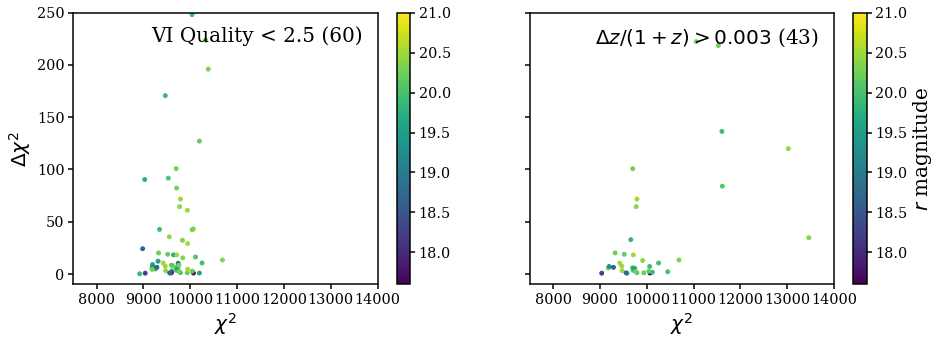

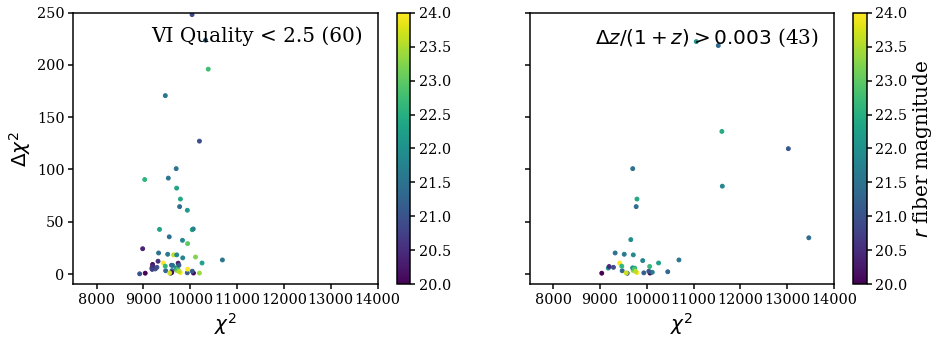

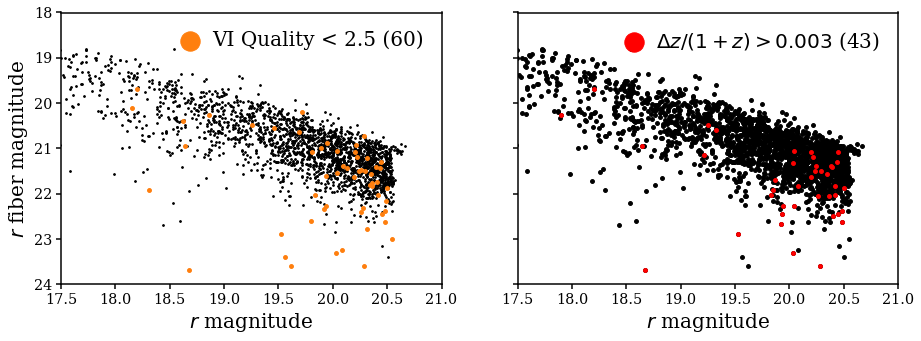

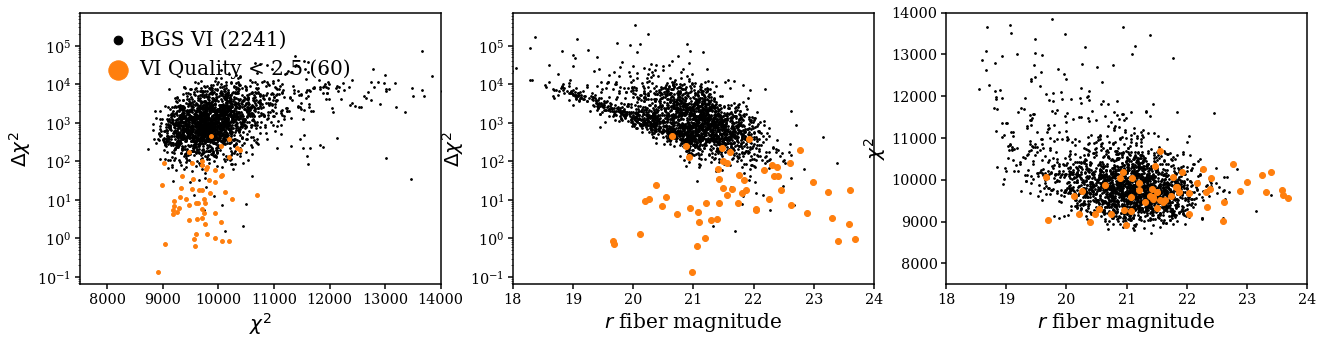

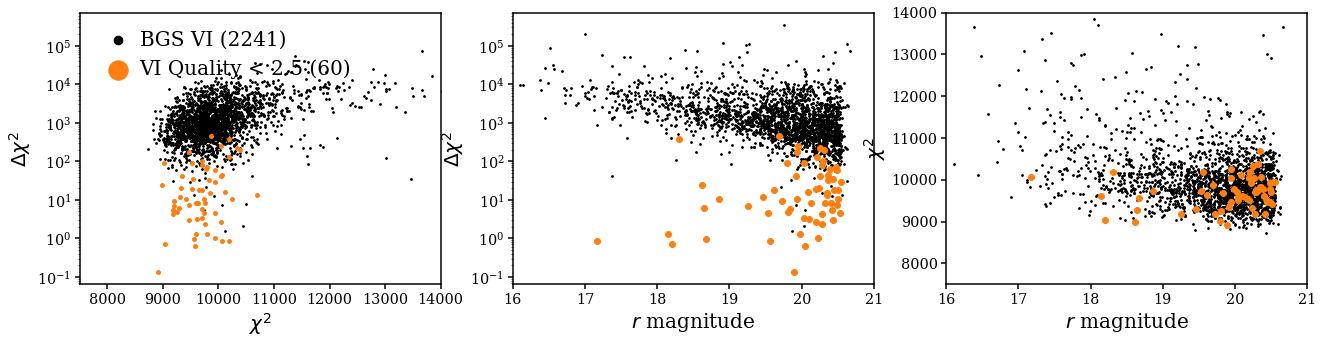

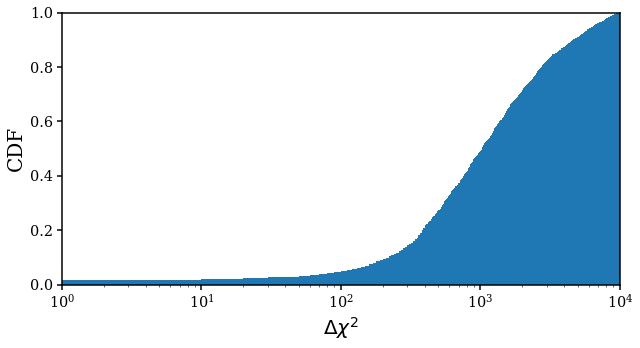

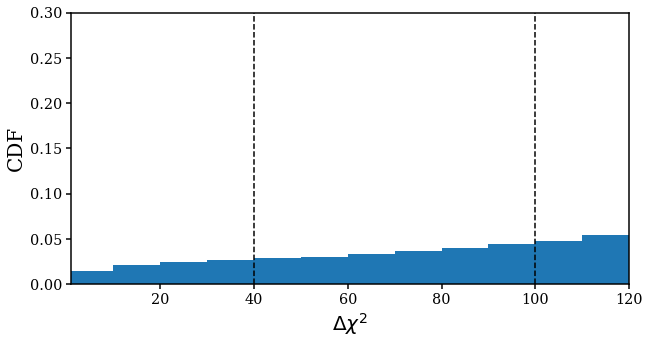

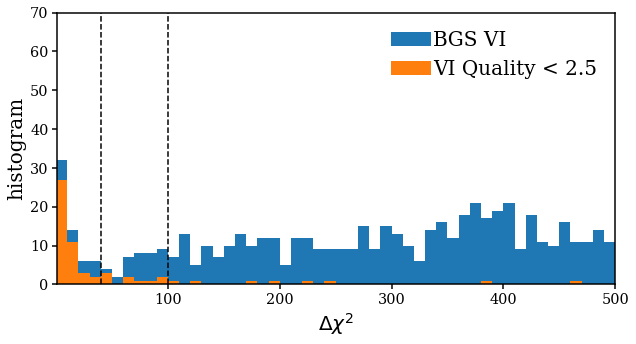

In [11]:
dir_3xcoadd = '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66003/20200315/'

petals = np.unique([int(fcoadd.split('-')[1]) for fcoadd in glob.glob(os.path.join(dir_3xcoadd, 'coadd-*-66003-20200315.fits'))])

n_bgs, n_match = 0, 0
ids, fluxes, rmags, rfibs, z_rrs, zwarns, chi2s, dchi2s = [], [], [], [], [], [], [], []
for petal in petals: 
    # read coadd file
    f_coadd = os.path.join(dir_3xcoadd, 'coadd-%i-66003-20200315.fits' % petal)
    coadd = fitsio.read(f_coadd)

    coadd_wave = fitsio.read(f_coadd, ext=2)
    coadd_flux = fitsio.read(f_coadd, ext=3)

    # read zbest files
    f_zbest = f_coadd.replace('coadd-', 'zbest-')
    zbest = fitsio.read(f_zbest)

    # only keep BGS targets
    is_BGS  = (coadd['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0
    # remove galaxies with no flux...
    gal_cut = np.ones(len(coadd['CMX_TARGET'])).astype(bool)#is_BGS & (np.sum(coadd_flux, axis=1) != 0)
    n_bgs += np.sum(gal_cut)

    ids.append(coadd['TARGETID'][gal_cut])
    fluxes.append(coadd_flux)

    rmags.append(22.5 - 2.5 * np.log10(coadd['FLUX_R'][gal_cut]))
    rfibs.append(22.5 - 2.5 * np.log10(coadd['FIBERFLUX_R'][gal_cut]))

    z_rrs.append(zbest['Z'][gal_cut])
    zwarns.append(zbest['ZWARN'][gal_cut])

    chi2s.append(zbest['CHI2'][gal_cut])
    dchi2s.append(zbest['DELTACHI2'][gal_cut])


# match VI targets to coadd targets 
ids = np.concatenate(ids)
_, m_vi, _m_coadd = np.intersect1d(vi_id, ids, return_indices=True)
isort = np.argsort(m_vi)
m_coadd = _m_coadd[isort]
assert np.array_equal(m_vi[isort], np.arange(len(vi_id)))
print('  %i of %i BGS targets have matches to VI' % (len(m_vi), n_bgs))
assert np.array_equal(vi_id, ids[m_coadd])

fluxes = np.concatenate(fluxes)[m_coadd]

rmags = np.concatenate(rmags)[m_coadd]
rfibs = np.concatenate(rfibs)[m_coadd]

z_rrs = np.concatenate(z_rrs)[m_coadd]
zwarns = np.concatenate(zwarns)[m_coadd]

chi2s = np.concatenate(chi2s)[m_coadd]
dchi2s = np.concatenate(dchi2s)[m_coadd]

bad_vi = (qa_flag < 2.5)
print('  %i of %i have QA flag < 2.5' % (np.sum(bad_vi), len(bad_vi)))

rr_mismatch = np.abs(z_rrs - ztrue)/(1. + ztrue) > 0.003
print('  %i of %i have delta z/(1+z) > 0.003' % (np.sum(rr_mismatch), len(rr_mismatch)))

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(121)
sub.scatter(chi2s, dchi2s, s=3, c='k', label='BGS VI (%i)' % len(bad_vi))
sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
sub.legend(loc='upper left', fontsize=20, handletextpad=0.1, markerscale=5)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_yscale('log')

sub = fig.add_subplot(122)
sub.scatter(chi2s, dchi2s, s=3, c='k')
sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=15, c='r', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
sub.legend(loc='upper left', fontsize=20, handletextpad=0.1, markerscale=5)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_yscale('log')
sub.set_yticklabels([])

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(121)
_plt = sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c=rmags[bad_vi], s=15, vmin=17.6, vmax=21.)
cbar = fig.colorbar(_plt, ax=sub)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_ylim(-10, 250)
sub.text(0.95, 0.95, 'VI Quality < 2.5 (%i)' % np.sum(bad_vi), transform=sub.transAxes, ha='right', va='top', fontsize=20)

sub = fig.add_subplot(122)
_plt = sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=15, c=rmags[rr_mismatch], vmin=17.6, vmax=21.)
cbar = fig.colorbar(_plt, ax=sub)
cbar.set_label('$r$ magnitude', fontsize=20)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_ylim(-10, 250)
sub.set_yticklabels([])    
sub.text(0.95, 0.95, '$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch), transform=sub.transAxes, ha='right', va='top', fontsize=20)

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(121)
_plt = sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c=rfibs[bad_vi], s=15, vmin=20., vmax=24.)
cbar = fig.colorbar(_plt, ax=sub)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_ylim(-10, 250)
sub.text(0.95, 0.95, 'VI Quality < 2.5 (%i)' % np.sum(bad_vi), transform=sub.transAxes, ha='right', va='top', fontsize=20)

sub = fig.add_subplot(122)
_plt = sub.scatter(chi2s[rr_mismatch], dchi2s[rr_mismatch], s=15, c=rfibs[rr_mismatch], vmin=20., vmax=24.)
cbar = fig.colorbar(_plt, ax=sub)    
cbar.set_label('$r$ fiber magnitude', fontsize=20)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_ylim(-10, 250)
sub.set_yticklabels([])    
sub.text(0.95, 0.95, '$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch), transform=sub.transAxes, ha='right', va='top', fontsize=20)


fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(121)
sub.scatter(rmags, rfibs, c='k', s=3)
sub.scatter(rmags[bad_vi], rfibs[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)    
sub.set_xlabel(r'$r$ magnitude', fontsize=20)
sub.set_xlim(17.5, 21)
sub.set_ylabel(r'$r$ fiber magnitude', fontsize=20)
sub.set_ylim(24., 18)    
sub = fig.add_subplot(122)
sub.scatter(rmags, rfibs, s=15, c='k')    
sub.scatter(rmags[rr_mismatch], rfibs[rr_mismatch], s=15, c='r', label='$\Delta z/(1+z) > 0.003$ (%i)' % np.sum(rr_mismatch))
sub.legend(loc='upper right', fontsize=20, handletextpad=0.1, markerscale=5)
sub.set_xlabel(r'$r$ magnitude', fontsize=20)
sub.set_xlim(17.5, 21)
sub.set_ylim(24., 18)
sub.set_yticklabels([])    


fig = plt.figure(figsize=(22, 5))
sub = fig.add_subplot(131)
sub.scatter(chi2s, dchi2s, s=3, c='k', label='BGS VI (%i)' % len(bad_vi))
sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
sub.legend(loc='upper left', fontsize=20, handletextpad=0.1, markerscale=5)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_yscale('log')

sub = fig.add_subplot(132)
sub.scatter(rfibs, dchi2s, s=3, c='k')
sub.scatter(rfibs[bad_vi], dchi2s[bad_vi], c='C1')
sub.set_xlabel(r'$r$ fiber magnitude', fontsize=20)
sub.set_xlim(18, 24)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_yscale('log')

sub = fig.add_subplot(133)
sub.scatter(rfibs, chi2s, s=3, c='k')
sub.scatter(rfibs[bad_vi], chi2s[bad_vi], c='C1')
sub.set_xlabel(r'$r$ fiber magnitude', fontsize=20)
sub.set_xlim(18, 24)
sub.set_ylabel(r'$\chi^2$', fontsize=20)
sub.set_ylim(7500., 14000)


fig = plt.figure(figsize=(22, 5))
sub = fig.add_subplot(131)
sub.scatter(chi2s, dchi2s, s=3, c='k', label='BGS VI (%i)' % len(bad_vi))
sub.scatter(chi2s[bad_vi], dchi2s[bad_vi], c='C1', s=15, label='VI Quality < 2.5 (%i)' % np.sum(bad_vi))
sub.legend(loc='upper left', fontsize=20, handletextpad=0.1, markerscale=5)
sub.set_xlabel(r'$\chi^2$', fontsize=20)
sub.set_xlim(7500., 14000)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_yscale('log')

sub = fig.add_subplot(132)
sub.scatter(rmags, dchi2s, s=3, c='k')
sub.scatter(rmags[bad_vi], dchi2s[bad_vi], c='C1')
sub.set_xlabel(r'$r$ magnitude', fontsize=20)
sub.set_xlim(16, 21)
sub.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_yscale('log')

sub = fig.add_subplot(133)
sub.scatter(rmags, chi2s, s=3, c='k')
sub.scatter(rmags[bad_vi], chi2s[bad_vi], c='C1')
sub.set_xlabel(r'$r$ magnitude', fontsize=20)
sub.set_xlim(16, 21)
sub.set_ylabel(r'$\chi^2$', fontsize=20)
sub.set_ylim(7500., 14000)



fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.hist(dchi2s, range=(0, 1e4), cumulative=True, density=True, bins=1000)
sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_xlim(1, 1e4)
sub.set_xscale('log')
sub.set_ylabel('CDF', fontsize=20)
sub.set_ylim(0., 1.)

fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.hist(dchi2s, range=(0, 1e4), cumulative=True, density=True, bins=1000)
sub.plot([40., 40.], [0., 1.], c='k', ls='--')
sub.plot([100., 100.], [0., 1.], c='k', ls='--')
sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_xlim(1, 120)
sub.set_ylabel('CDF', fontsize=20)
sub.set_ylim(0., 0.3)


fig = plt.figure(figsize=(10, 5))
sub = fig.add_subplot(111)
sub.hist(dchi2s, range=(0, 1e4), bins=1000, label='BGS VI')
sub.hist(dchi2s[bad_vi], range=(0, 1e4), bins=1000, label='VI Quality < 2.5')
sub.plot([40., 40.], [0., 100.], c='k', ls='--')
sub.plot([100., 100.], [0., 100.], c='k', ls='--')    
sub.legend(loc='upper right', fontsize=20, handletextpad=0.1)
sub.set_xlabel(r'$\Delta \chi^2$', fontsize=20)
sub.set_xlim(1, 500)
#sub.set_xscale('log')
sub.set_ylabel('histogram', fontsize=20)
sub.set_ylim(0., 70.)    
    
print(np.sum(dchi2s < 40), np.sum(dchi2s < 100), np.sum((dchi2s > 40) & (dchi2s < 100)))
print(np.sum(dchi2s < 40)/len(dchi2s), np.sum(dchi2s < 100)/len(dchi2s), np.sum((dchi2s > 40) & (dchi2s < 100))/len(dchi2s))    
print(np.sum(bad_vi & (dchi2s < 40)), np.sum(dchi2s < 40))
print(np.sum(bad_vi & (dchi2s < 40))/np.sum(dchi2s < 40))

print(np.sum(bad_vi & (dchi2s < 100)), np.sum(dchi2s < 100))
print(np.sum(bad_vi & (dchi2s < 100))/np.sum(dchi2s < 100))    
print(np.sum(bad_vi & (dchi2s > 40) & (dchi2s < 100))/np.sum((dchi2s > 40) & (dchi2s < 100)))